##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub Action Recognition Model


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Colab demonstrates use of action recognition from video data using the
[tfhub.dev/deepmind/i3d-kinetics-400/1](https://tfhub.dev/deepmind/i3d-kinetics-400/1) module.

The underlying model is described in the paper "[Quo Vadis, Action Recognition? A New
Model and the Kinetics Dataset](https://arxiv.org/abs/1705.07750)" by Joao
Carreira and Andrew Zisserman. The paper was posted on arXiv in May 2017, and
was published as a CVPR 2017 conference paper.
The source code is publicly available on
[github](https://github.com/deepmind/kinetics-i3d).

"Quo Vadis" introduced a new architecture for video classification, the Inflated
3D Convnet or I3D. This architecture achieved state-of-the-art results on the UCF101
and HMDB51 datasets from fine-tuning these models. I3D models pre-trained on Kinetics
also placed first in the CVPR 2017 [Charades challenge](http://vuchallenge.org/charades.html).

The original module was trained on the [kinetics-400 dateset](https://deepmind.com/research/open-source/open-source-datasets/kinetics/)
and knows about 400 diferrent actions.
Labels for these actions can be found in the
[label map file](https://github.com/deepmind/kinetics-i3d/blob/master/data/label_map.txt).

In this Colab we will use it recognize activites in videos from a UCF101 dataset.

## Setup

In [2]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [0]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [5]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


# Using the UCF101 dataset

In [6]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

In [7]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_HighJump_g01_c01.avi")
sample_video = load_video(video_path)

Fetching http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_HighJump_g01_c01.avi => /tmp/tmppt613trz/v_HighJump_g01_c01.avi


In [0]:
#to_gif(sample_video)

In [9]:
sample_video.shape

(155, 224, 224, 3)

In [10]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


 the i3d model and print the top-5 action predictions.

In [0]:
def predict(sample_video):
  # Add a batch axis to the to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  for i in np.argsort(probabilities)[::-1][:1]:
      if probabilities[i]* 100>50:
       print("Action going on is:")
       print(f"  {labels[i]}:{probabilities[i] * 100:5.2f}%") 
     

In [12]:
predict(sample_video)

Action going on is:
  high jump:72.45%


Now try a new video, from: https://commons.wikimedia.org/wiki/Category:Videos_of_sports

How about [this video](https://commons.wikimedia.org/wiki/File:End_of_a_jam.ogv) by Patrick Gillett: 

In [13]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  26.4M      0  0:00:02  0:00:02 --:--:-- 26.4M


To add video click on upload button and select your video,then directly write the name of video with format(.mp4) like i have done below for eg-cricket.mp4 


In [0]:
video_path = "cricket.mp4"

In [0]:
sample_video = load_video(video_path)

Check frames per second of uploaded video by going to properties than details section, as here i got 25 frames per second for format.mp4 video. 

375 is the no. of frames in the video,as we want our result for integer value of seconds like 1 sec ,10seconds in video we will exclude extra frames which will come after the last second in video

In [16]:
sample_video.shape

(375, 224, 224, 3)

As our video is of 15 seconds but if some frames comes after that we will exclude them,you replace 25 with your no. of frames in 4th line (k=j%25)

In [17]:
k=0
#sample_video = load_video(video_path)
j=sample_video.shape[0]
k=j%25
j=j-k
print(j)


375


In [0]:
#to_gif(sample_video)

Again replace 25,with your no. of frames,here you have 3 times 25 (in first for statement [0,j,25]),in 2nd line [i:i+25] and 3rd line i=i+25),to change threshold value (to detect activity at less or more possibility) go to 2nd for statement change value of 50 acoording to you in tis line (if probabilities[i]* 100>75:)


In input write activity for which your searching for it will predict start and end of the activity for you,give stop in input to stop execution.

['playing cricket', 'playing cricket', 'playing cricket']
Which activity u have to see
playing cricket
['start time is 5 and end time is 7', 'start time is 12 and end time is 12', 'start time is 14 and end time is 14']
Which activity u have to see
stop


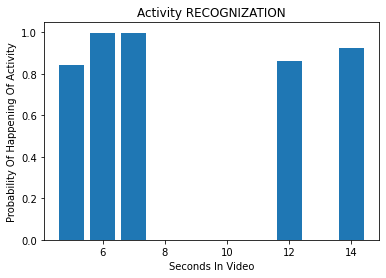

In [31]:
o=[]
r=[]
z=[]
l=0
k=[]
d=[]
z=[]
for i in range(0,j,25):
  sample_video = load_video(video_path)[i:i+25]
  i=i+25
  l=l+1
#  print(f"At {l}th second is")
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  for i in np.argsort(probabilities)[::-1][:1]:
   if labels[i] == "triple jump":
    k.append(l) 
    d.append("running")
    z.append(probabilities[i])
   else: 
    if probabilities[i]* 100>75:
     z.append(probabilities[i])
 #    print("Action going on is:")
 #    print(f"  {labels[i]:22}:{probabilities[i] * 100:5.2f}%")
     k.append(l)
     d.append(labels[i])
    else:
     pass   
plt.bar(k,z)
plt.title("Activity RECOGNIZATION")
plt.xlabel('Seconds In Video')
plt.ylabel('Probability Of Happening Of Activity')
  
#k=[1,3,4,5,7,8,9,11]
#d=["cric","foot","volley","bsball","foot","dotch","foot","baskt"]
h=k.copy()
h.remove(k[0])
#print(h)
r.append(k[0])
m=int(len(h))
for i in k:
 i=int(i)
for i in h:
 i = int(i)
for i in range(m):
 if h[i]!=k[i]+1:
  o.append((h[i-1]))
  r.append((h[i]))
o.append(k[-1])
p=int(len(r))
if k[0]+1!=k[1]:
 o[0]=k[0]
 for i in range(p):
  z.append(f"start time {r[i]} and end time {o[i]}")
#  print(f"start time of activity is {r[i]} and end time of activity is {o[i]}")
else:
 for i in range(p):
  z.append(f"start time {r[i]} and end time {o[i]}")
#  print(f"start time of activity is {r[i]} and end time of activity is {o[i]}")
#print(z)
#print(r)
#print(o)
b=[]
e=[]
for l,z in enumerate(k):
 for item in r:
  if k[l]==item:
   b.append(l)
#print(b)
for u,i in enumerate(b):
 i=int(i)
 e.append(d[i])
print(e)
k.clear()
while(True):
 print("Which activity u have to see")
 a = input()
 if a=="stop":
   break  
 for u,i in enumerate(e):
  if a==i:
   k.append(f"start time is {r[u]} and end time is {o[u]}")
 if len(k)==0:
  print("Please give some valid input activity")
 print(k)
 k.clear()

Here also replace 30 with your no. of frames and check result by giving your start and end time of activity  examlpe here i have written 5 as start and 8 as my end time+1 as activity is also happening on 7th second


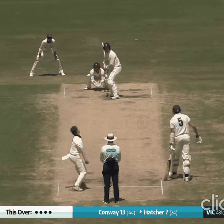

In [39]:
video_path = "cricket.mp4"
sample_video = load_video(video_path)
to_gif(sample_video[5*25:8*25])

You can use multiple times to_gif() function like above to check your results


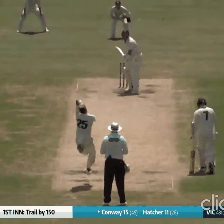

In [37]:
to_gif(sample_video[12*25:13*25])


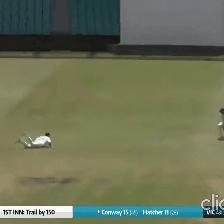

In [38]:
to_gif(sample_video[14*25:15*25])

In [0]:
#to_gif(sample_video[14*25:15*25])

In [0]:
#to_gif(sample_video[36*24:38*24])

In [0]:
#to_gif(sample_video[37*25:38*25])

In [26]:
"""l=0
k=[]
d=[]
for i in range(0,j,30):
  sample_video = load_video(video_path)[i:i+30]
  i=i+30
  l=l+1
  print(f"At {l}th second is")
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  for i in np.argsort(probabilities)[::-1][:1]:
    if probabilities[i]* 100>80:
     print("Action going on is:")
     print(f"  {labels[i]:22}:{probabilities[i] * 100:5.2f}%")
     k.append(l)
     d.append(labels[i])
    else:
      pass
print(k)  
print(d)    

sample_video = load_video(video_path)[0:1000]
j=sample_video.shape[0]
print(j)"""

'l=0\nk=[]\nd=[]\nfor i in range(0,j,30):\n  sample_video = load_video(video_path)[i:i+30]\n  i=i+30\n  l=l+1\n  print(f"At {l}th second is")\n  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]\n\n  logits = i3d(model_input)[\'default\'][0]\n  probabilities = tf.nn.softmax(logits)\n\n  for i in np.argsort(probabilities)[::-1][:1]:\n    if probabilities[i]* 100>80:\n     print("Action going on is:")\n     print(f"  {labels[i]:22}:{probabilities[i] * 100:5.2f}%")\n     k.append(l)\n     d.append(labels[i])\n    else:\n      pass\nprint(k)  \nprint(d)    \n\nsample_video = load_video(video_path)[0:1000]\nj=sample_video.shape[0]\nprint(j)'

In [27]:
"""q=0
t=int(len(h))
for i in range(t):
 print(f"At {h[q]} second {n[q]} activity is going on ")
 q=q+1"""

'q=0\nt=int(len(h))\nfor i in range(t):\n print(f"At {h[q]} second {n[q]} activity is going on ")\n q=q+1'

In [28]:
"""o=[]
r=[]
x=h.copy()
x.remove(h[0])
print(x)
r.append(h[0])
m=int(len(x))
for i in h:
 i=int(i)
for j in x:
 j = int(j)
for n in range(m):
 if x[n]!=h[n]+1:
  o.append((x[n-1]))
  r.append((x[n]))
o.append(h[-1])
h=int(len(r))

for q in range(h):
 print(f"start time of activity is {r[q]} and end time of activity is {o[q]}")"""


'o=[]\nr=[]\nx=h.copy()\nx.remove(h[0])\nprint(x)\nr.append(h[0])\nm=int(len(x))\nfor i in h:\n i=int(i)\nfor j in x:\n j = int(j)\nfor n in range(m):\n if x[n]!=h[n]+1:\n  o.append((x[n-1]))\n  r.append((x[n]))\no.append(h[-1])\nh=int(len(r))\n\nfor q in range(h):\n print(f"start time of activity is {r[q]} and end time of activity is {o[q]}")'